# The Problem

In the last lecture, we noticed that scientific proverbs are good at providing general guidance. But inevitably we run into cases where the proverbs don't provide clear guidance. Proverbs around representative sampling are similarly unhelpful. Here is an entry out of a little [medical resource](https://www.understandinghealthresearch.org/useful-information/common-sources-of-bias-2):

> Research samples can sometimes under-represent certain people or groups, and over–represent others. This is called sample selection bias. The best way to select people for research is using the basis of chance, in other words, so that everyone in the population being investigated has an equal chance of being selected. This is called randomisation, because people are randomly selected to take part in the study.

In real life, we never have the option of selecting from a pool of everyone by chance. Normally, we cannot even get close to the ideal. Just think about how hard it would be to even get a complete list of Canadian citizens with contact information. Instead, behavioural science researchers rely on "convenience samples" of university students in North American and Europe. The Henrich, Heine, and Norenzayan piece goes further and describes the typical psychology sample as WEIRD (Western, Educated, Industrialized, Rich and Democratic). The response to this practice often heads towards extremes - some might say "nearly all behavioural science research is worthless." Other disagree and ask "what else are you going to do? Some data is better than no data."

It would help if could have a framework to know what we can make of such samples - how much evidential value do they carry? Under what assumptions? We have two tools at our disposal:

- Empirical data on similar psychological phenomena
- Multi-level models to represent cross-cultural effect heterogeneity

This lecture will be mostly focused on the model side. The reading provides an extremely detailed discussion about which effects tend to show cross-cultural similarities and differences. Models are just formalized assumptions. You have know stuff to make good assumptions. So the reading provides the raw material that we will synthesize into the model.

# How to combine data from two different populations?

Imagine we've already conducted the Asch conformity experiment at Swathmore college. Now we want to explore how much the effect varies around the world - do most cultures have a similar number of conformists? Or, is there a lot of cross-cultural variety? A good test case would be India. It has a more collectivist culture than America does. There are multi-century long processes that have created stable and strong cultural differences. So it is plausible that people tend to conform to group judgements more in India. How should we construct a model though? It will take a long time we before we have a sensible model that can explore this questions so prepare for quite the journey.

We have a lot of set up to do, first packages.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

Second, reload the US asch data.

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_experiment_1_data"

us_data = pd.read_csv(url)
data_treatment = us_data[us_data.treatment == 1]
us_mistakes_treatment = data_treatment.mistakes.values

Third, refit the old model.

In [3]:
with pm.Model() as model_1:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=us_mistakes_treatment)

    trace_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [4]:
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.604,0.080,0.449,0.748,0.002,0.001,2111.0,2674.0,1.0
w[1],0.396,0.080,0.252,0.551,0.002,0.001,2111.0,2674.0,1.0
p0,0.117,0.024,0.076,0.165,0.001,0.000,2002.0,1735.0,1.0
p1,0.639,0.044,0.552,0.721,0.001,0.001,2077.0,2429.0,1.0


Notably, we estimated that proportion of independents (non-conformist) in the American sample is around 0.6. So that's the quantity we need to pay attention to throughout this lesson. We'll assume that conformists typically make mistakes 60% of the time and that independents typically make mistakes 10% of the time.

In the last lecture, we learned that a good first step is to build a simulation that generates synthetic (fake, artificial, or simulated) data. Testing out our statistical models on synthetic data can provide clues as to what the right model is. We'll reload our simulate `experiments_function` too so that we generate synthetic data.

In [3]:
def simulate_experiment(rate=0.60,independents_p=0.1,conformist_p=0.6,n=12,precision=100):
    '''
    rate_of_independents - what proportion of the subjects should be 
    independents, the rest are conformists.
    independents_p - the probability of a mistake from an independent
    conformist_p - the probability of a mistake from a conformist
    n - the number of critical trials in the experiment
    precision - the number of simulated people 
    '''

    data = []

    for i in range(precision):
        
        # decide whether they are independent or conformist
        
        if np.random.choice([1,0],p=[rate, 1-rate]) == 1:
            
            # they are an independent
            # then their errors come from a binomial
            # with a very low error rate
            
            errors = stats.binom(p=independents_p,n=n).rvs()
            
        else:
            
            # they are a conformist
            # then their errors come from a binomial
            # with a high error rate

            errors = stats.binom(p=conformist_p,n=n).rvs()
            
        data.append(errors)

    return np.array(data)

Let's assume the proportion of independents is smaller in India, at 0.4.

In [6]:
# I'm adding a random seed. 
# This fixes the random number generators in numpy/scipy
# so that they produce the same results
# if you run the cells in the same order
# below I talk about specific results
# so I need them to be fairly stable

seed = np.random.seed(13579) 
india_data = simulate_experiment(rate=0.4,independents_p=0.1,conformist_p=0.6,n=12,precision=50)

We can see that there are more mistakes made overall and fewer people are bunched up near 0 mistakes.

In [ ]:
mistakes = list(india_data)
outcomes = range(13)
counts = []

for i in outcomes:
  matches = mistakes.count(i)
  counts.append(matches)

plt.bar(outcomes,counts)

We've done the necessary setup. We have two different datasets. The question I want to explore for the next while is:

*What is the right way to combine our US and India data?*

We have three options:
1. Estimate one model, combining all the data into a single group
2. Estimate two seperate models, keeping all the data seperate
3. A multi-level model.

It's a tricky question between the natural thing to do is either (1) or (2). I want to show you that neither one is sensible and a multilevel model is the best way to go. Once we have multi-level models, we'll be able to revisit our problem about generalizability.

## Combine the data, one model

Combining all the data has a very natural motivation. In previous discussions of priors, we've talked about how you can use past studies to help inform your priors. After all, if you've done a study in the past, the posterior you learned in that study *should* be the prior you take with you into the new study. If you don't use that well-informed prior, it is like forgetting what we have already learned. That violates one of principles of designing good priors - (1) use what you know.

If you plug all your data into one model, it does exactly that. It learns everything there is to learn from the us data and then turns to the india data and learns from that too.

Visually, our combined that looks like this.

<BarContainer object of 13 artists>

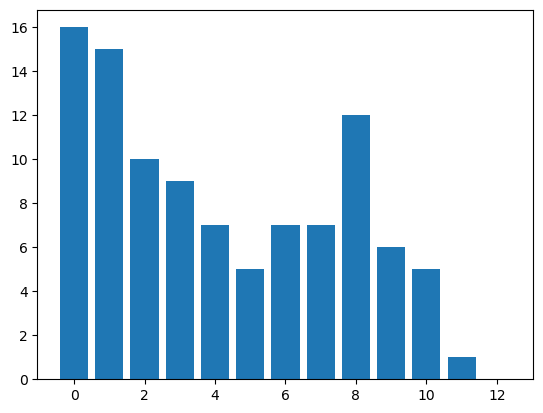

In [6]:
# np.concatenate joins to arrays together

combined_data = np.concatenate((india_data,us_mistakes_treatment))

# visualized the combined_data

mistakes = list(combined_data)

outcomes = range(13)
counts = []

for i in outcomes:
  matches = mistakes.count(i)
  counts.append(matches)

plt.bar(outcomes,counts)

Coding up the model only requires switching out the name of the dataset

In [28]:
with pm.Model() as model_combined:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=combined_data)

    trace_combined = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [29]:
az.summary(trace_combined)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.534,0.056,0.434,0.644,0.001,0.001,3534.0,2564.0,1.0
w[1],0.466,0.056,0.356,0.566,0.001,0.001,3534.0,2564.0,1.0
p0,0.121,0.017,0.090,0.153,0.000,0.000,2978.0,2216.0,1.0
p1,0.610,0.027,0.561,0.661,0.000,0.000,3716.0,3132.0,1.0


The summary looks reasonable. Our two samples were of similar sizes. So the resulting posterior will typically looks like the average of the two effects. The mean of the `p0` and `p1` are in the same places - as they should be. We didn't change those parameters between India and the US. The weight `w` parameters have moved to be in-between the `w` of the US (estimated to be around 0.6) and the `w` of the India (programmed to be 0.4).

**The problem** - Averaging the weight parameters across the two countries covers up an important bit of structure. We know that the two countries (at least in the simulated version of India) have different weight parameters. After all, we assumed India has fewer independents than the US. When we average, we get an estimate that doesn't accurately describe either country. If we took this model back to the US and tried to predict the results of a new Asch experiment, we'd likely be off. So this exploration tells us we want a model that can capture the fact that different societies have different weight parameters.

## Seperate the data, seperate the models

Noticing the problem above, we might be inclined keep the two datasets seperate and try to estimate two seperate weight parameters. 

This is a nice opportunity to show off some neat features of PyMC. We can use two different likelihood functions at once. Each likelihood function is allowed to share some parameters - both societies will share the same `p0`/`p1` parameters. We've assumed those parameters don't vary across cultures. If you are an independently-minded person in the US, you have the same error rate as an independently-minded person in India. This gives us a very big sample size to estimate that feature of our model.

However, we can estimate seperate `w` parameters for each country and pass different `w`s to different likelihood functions.

In [30]:
with pm.Model() as model_seperated:

    # mixture weights

    w_us = pm.Dirichlet('w_us',[1,1])
    w_india = pm.Dirichlet('w_india',[1,1])

    # mixture components

    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y_us = pm.Mixture('error_us',w=w_us,comp_dists=components,observed=us_mistakes_treatment)
    y_india = pm.Mixture('error_india',w=w_india,comp_dists=components,observed=india_data)

    trace_seperated = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_us, w_india, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


The summary reveal that the mean `w_us` is pretty similar to where it was before (0.6). Meanwhile the mean `w_india` is close to it's true value of 0.4.

In [31]:
az.summary(trace_seperated)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_us[0],0.594,0.075,0.454,0.735,0.001,0.001,4002.0,2909.0,1.0
w_us[1],0.406,0.075,0.265,0.546,0.001,0.001,4002.0,2909.0,1.0
w_india[0],0.476,0.074,0.347,0.622,0.001,0.001,4561.0,3025.0,1.0
w_india[1],0.524,0.074,0.378,0.653,0.001,0.001,4561.0,3025.0,1.0
p0,0.122,0.017,0.090,0.153,0.000,0.000,3621.0,3129.0,1.0
p1,0.611,0.027,0.561,0.662,0.000,0.000,3397.0,2832.0,1.0


**The problem**- We've already noticed a problem with this approach. It throws out prior information. We've already learned something about the `w` parameter from studying US undergrads. It would be extremely odd to think that Indian psychology is *so* different that we learn nothing about it by studying the US. Non-western cultures are not alien planets. Humans share a lot of their psychology in common across the world. Cultural influence flows back and forth between the US and India. The more the two cultures have in common, the more our prior information should matter.

Moreover, imagine we try to extend our study to the next society. What should we assume about them? Do we predict they will conform to the US parameter, the India parameter, or do we just assume nothing about them at all and invent a third `w` parameter? If we treat every society as wholly seperate entity, it makes any form of generalization impossible.

So we are stuck. We want to incorporate prior information. But pooling all the data together is clearly wrong. What would be really nice is if we could balance these two features. We *partially* incorporate our prior information. If we had another parameter that represents how similar the cultures are, we might be able to control the amount of cross-culture influence of the priors. 

# The Multi-level model

The multi-level model does exactly that. It combines information across two or more groups while simultaneously estimating how similar the two groups are. The statistical details are intense so I'm going to introduce this model in very gentle stages. The first stage is to build a generative simulation that uses a multi-level structure.

Once we start imagine that `w` parameters vary from culture to culture, it is a bit like saying we have a population of `w` parameters. If we studied 10 societies, we could draw a little picture showing the variation in `w`s.

Text(0.5, 1.0, 'samples of weight parameters from 10 cultures')

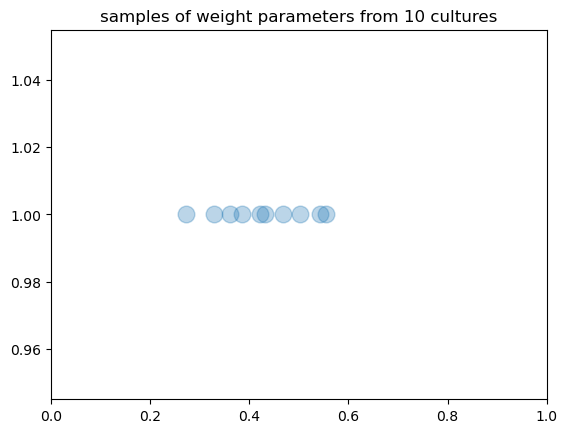

In [61]:
samples = stats.beta(10,13).rvs(10)
plt.plot(samples,np.ones(10),'o',markersize=12,alpha=0.3)
plt.xlim([0,1])
plt.title("samples of weight parameters from 10 cultures")

When looking at a picture like this, it is natural to say think there is some global distribution of `w` parameters. Maybe every culture is very similar. That would be a narrow distribution with low variation. Maybe they are not. That would be a wide distribution. We could even assumes it follows some specific distribution, like a beta. Here I construct a global distribution that is fairly narrow but includes `0.4` and `0.6`, so it is consistent with our US/India example.

Text(0.5, 1.0, "The global distribution of w's is a beta")

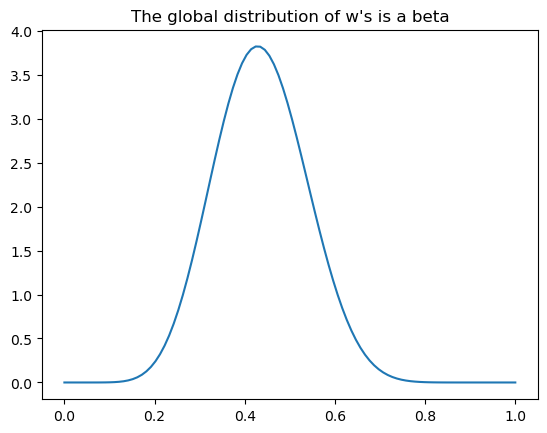

In [60]:
grid = np.linspace(0,1,100)
rate = stats.beta(10,13).pdf(grid)

plt.plot(grid,rate)
plt.title("The global distribution of w's is a beta")

Now here is the core idea of the simulation-side of a multi-level model. Imagine we visited three cultures from around the world at random. That is like taking three samples from a beta. Then we plugged those samples into our mixture model to generate datasets.

In [4]:
# multi-level simulation

rate = stats.beta(18,23).rvs(3)

print("weight samples:" + str(rate))

group_0_data = simulate_experiment(rate=rate[0])
group_1_data = simulate_experiment(rate=rate[1])
group_2_data = simulate_experiment(rate=rate[2])


weight samples:[0.41206632 0.5314082  0.44623483]


We can play with this generative model by changing the beta distribution. Below I provide a simple slider interface for exploring how the multilevel mixture behaves when we are sampling three countries.

In [91]:
import ipywidgets as widgets

def draw_multilevel_mixture(a,b,p0,p1):
    fig = plt.figure(constrained_layout=True).subplot_mosaic(
        """
        AAA
        BCD
        """)

    global_dist = stats.beta(a,b)

    x = np.linspace(0,1,400)
    y = global_dist.pdf(x)
    y = y / sum(y)

    fig['A'].plot(x,y)

    ids = np.array([0,1,2])

    plot_id = ['B','C','D']
    plot_colors = ['tab:orange','tab:pink','tab:green']

    for i in range(3):
        rate = global_dist.rvs()
        print("w:" +str(rate))
        subgroup_data = simulate_experiment(rate=rate,independents_p=p0,conformist_p=p1,n=12,precision=50)
        
        fig['A'].plot(rate,[0],'o',color=plot_colors[i])
        fig[plot_id[i]].hist(subgroup_data,width=0.85,bins=10,color=plot_colors[i],density=True)
        fig[plot_id[i]].set_ylim([0,0.4])

widgets.interact_manual(draw_multilevel_mixture,
                a=widgets.FloatSlider(min=0,max=50,step=0.1,value=2),
                b=widgets.FloatSlider(min=0,max=50,step=0.1,value=2),
                p0=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                p1=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5));

interactive(children=(FloatSlider(value=2.0, description='a', max=50.0), FloatSlider(value=2.0, description='b…

This tool illustrates the big innovation of multi-level models. In normal statistical modeling, we assume that the data comes from some distribution and we use try to figure out which one. In multi-level modeling, we also assume the parameters themselves are random samples from a distribution. Each time you run the widget above, you get different random samples of the `w` parameters. If the parameters comes from a distribution, maybe we can estimate what that distribution is like, in exactly the same way we estimate which distribution the data came from.

## Programming a multi-level model in PyMC

Here's a multilevel model in PyMC.

In [12]:
with pm.Model() as model_multilevel_1:

    # global population priors

    mean = pm.Dirichlet('mean',[1,1])
    inverse_variance = pm.Exponential('inverse_variance',scale=1)
    hyper_parameter = mean * inverse_variance

    # mixture weights

    w0 = pm.Dirichlet('w0',hyper_parameter)
    w1 = pm.Dirichlet('w1',hyper_parameter)
    w2 = pm.Dirichlet('w2',hyper_parameter)

    # mixture components

    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y0 = pm.Mixture('error_0',w=w0,comp_dists=components,observed=group_0_data)
    y1 = pm.Mixture('error_1',w=w1,comp_dists=components,observed=group_1_data)
    y2 = pm.Mixture('error_2',w=w2,comp_dists=components,observed=group_2_data)

It should look quite familiar. Most of it follows the pattern we established in *Seperate the data, seperate the models*. The key difference is this - before the priors for the mixture weights (the Dirichlet distributions) had *numbers* in there. Now the priors have parameters in there `[a,b]`. Those parameters describe the global distribution of `w`. They are the same `a,b` from the widget above. That shows that we are uncertain about what parameters to plug into the priors. Moreover, these `a,b` parameters are shared across all three societies. When we learn about their value in the US, it shapes their value in India too. 

Okay but if we have parameters in a model, we need priors to describe those parameters. In our case, it is a pair of Dirichlet and Exponential priors at the top of the model. This is the really difficult part of multilevel modeling. Priors inside priors. *hyperpriors* are priors that describe the parameters inside other priors. It feels like madness. Whenever the math starts to float away from you, find a way to touch grass. Remember that these hyperpriors are just represent the range of plausible global distributions. So when we tune them, all we need to do is think about what the plausible global distributions of `w` parameters might look like. Or simply, how conformist could cultures plausibly be?

### Tuning the priors

In the previous lecture, we learned about how we can tune prior distributions through visualization. Let's take a look at what our hyperpriors imply about the global distribution of `w`. If we take a single random draw from our hyperpriors, it generates this prior distribution for `w`.

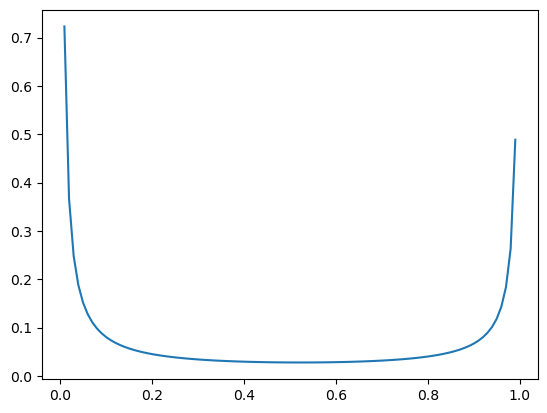

In [22]:
hyper_sample = pm.draw(hyper_parameter)
grid = np.linspace(0,1,100)
rate = stats.beta(hyper_sample[0],hyper_sample[1]).pdf(grid)

plt.plot(grid,rate)


Rerunning the cell above several times can generate intuition for what the typical draw looks like. Even better, we can look at a bunch of draws at once.

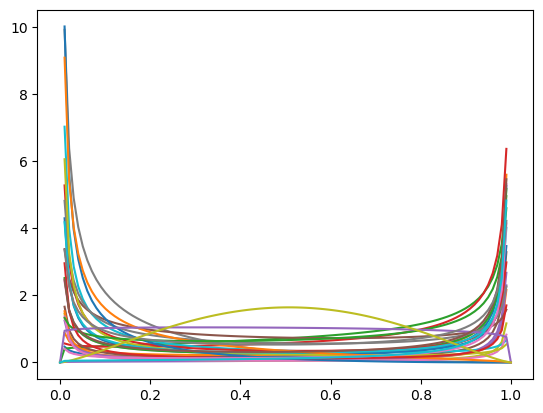

In [25]:
hyper_sample = pm.draw(hyper_parameter,draws=30)
grid = np.linspace(0,1,100)

for i in range(30):
    rate = stats.beta(hyper_sample[i,0],hyper_sample[i,1]).pdf(grid)
    plt.plot(grid,rate,alpha=1)

It is clear that these are rather implausible priors. They imply extremely high variation. They discount the idea that societies could all have fairly similar levels of conformity. They also imply a fairly high level of certainty that `w` is either $0$ or $1$. I don't feel so certain myself. So these priors smuggle in a lot of assumptions that we didn't mean to assume. The solution is to tinker - we'll make adjustments to the hyperpriors until they imply assumptions we find plausible. 

I wrote a little visualization function to make this a bit easier. We can see both of our hyperprior distributions on the top row and then 30 beta distributions they imply below. Tune the hyper prior distributions until they represent a range of possibilities you think is plausible.

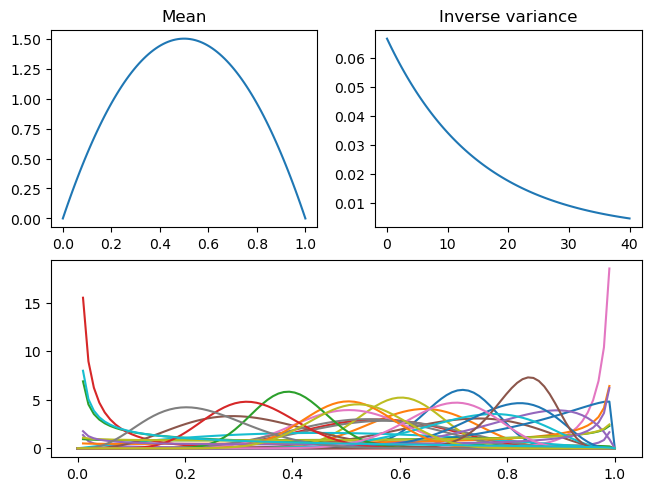

In [54]:
# manipulate the priors

mean = stats.dirichlet([2,2])
inverse_variance = stats.expon(scale=15)

# plotting routine

fig = plt.figure(constrained_layout=True).subplot_mosaic(
        """
        AB
        CC
        """)

mean_grid = np.linspace(0,1,100)
inverse_variance_grid = np.linspace(0,40,100)
beta_grid = np.linspace(0,1,100)

compliment = 1 - mean_grid
dirichlet_grid = np.stack((mean_grid,compliment),axis=1).T

a_prior = mean.pdf(dirichlet_grid)
b_prior = inverse_variance.pdf(inverse_variance_grid)

fig['A'].plot(mean_grid,a_prior)
fig['A'].set_title('Mean')
fig['B'].plot(inverse_variance_grid,b_prior)
fig['B'].set_title('Inverse variance')

for i in range(30):
    mean_sample = mean.rvs()
    inv_variance_sample = inverse_variance.rvs()

    hyper_parameter = mean_sample[0] * inv_variance_sample
    beta_prior = stats.beta(hyper_parameter[0],hyper_parameter[1]).pdf(beta_grid)

    plt.plot(beta_grid,beta_prior)


## Estimating a multi-level model

Once you feel comfortable with your hyper priors, let's test out the model on sythetic data. Remember, the goal is to see if it can recover the parameters that you plugged into a simulation to generate the data. Here `a = 10`, `b = 13`. The `w` parameters are randomly generated, but printed below the next cell. In this simulation, we'll also visit 12 cultures. We need to fairly good sample size of cultures to learn the global distribution parameters. 2 societies tells us very little. 10 is still not a lot. That's a very general problem. Hyper parameters are difficult to learn unless you have a lot of data.

In [39]:
# multi-level simulation

rate = stats.beta(10,13).rvs(12)

print("weight samples:" + str(rate))

global_data = []
for i in rate:
    culture_i = simulate_experiment(rate=i)
    global_data.append(culture_i)

weight samples:[0.5242046  0.52249145 0.40755901 0.3377934  0.49608104 0.23358351
 0.50721478 0.4151506  0.26287196 0.35038202 0.44800204 0.38147599]


The PyMC model gets a bit unruly. Relabeling everything by hand isn't fun!

In [46]:
with pm.Model() as model_multilevel_2:

    # global population priors

    mean = pm.Dirichlet('mean',[2,2])
    inverse_variance = pm.Exponential('inverse_variance',scale=15)
    hyper_parameter = mean * inverse_variance

    # cosmetic functions to make the model easier to summarize

    a = pm.Deterministic('a',hyper_parameter[0])
    b = pm.Deterministic('b',hyper_parameter[1])

    # mixture weights

    w0 = pm.Dirichlet('w0',hyper_parameter)
    w1 = pm.Dirichlet('w1',hyper_parameter)
    w2 = pm.Dirichlet('w2',hyper_parameter)
    w3 = pm.Dirichlet('w3',hyper_parameter)
    w4 = pm.Dirichlet('w4',hyper_parameter)
    w5 = pm.Dirichlet('w5',hyper_parameter)
    w6 = pm.Dirichlet('w6',hyper_parameter)
    w7 = pm.Dirichlet('w7',hyper_parameter)
    w8 = pm.Dirichlet('w8',hyper_parameter)
    w9 = pm.Dirichlet('w9',hyper_parameter)
    w10 = pm.Dirichlet('w10',hyper_parameter)
    w11 = pm.Dirichlet('w11',hyper_parameter)

    # mixture components

    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    pm.Mixture('error_0',w=w0,comp_dists=components,observed=global_data[0])
    pm.Mixture('error_1',w=w1,comp_dists=components,observed=global_data[1])
    pm.Mixture('error_2',w=w2,comp_dists=components,observed=global_data[2])
    pm.Mixture('error_3',w=w3,comp_dists=components,observed=global_data[3])
    pm.Mixture('error_4',w=w4,comp_dists=components,observed=global_data[4])
    pm.Mixture('error_5',w=w5,comp_dists=components,observed=global_data[5])
    pm.Mixture('error_6',w=w6,comp_dists=components,observed=global_data[6])
    pm.Mixture('error_7',w=w7,comp_dists=components,observed=global_data[7])
    pm.Mixture('error_8',w=w8,comp_dists=components,observed=global_data[8])
    pm.Mixture('error_9',w=w9,comp_dists=components,observed=global_data[9])
    pm.Mixture('error_10',w=w10,comp_dists=components,observed=global_data[10])
    pm.Mixture('error_11',w=w11,comp_dists=components,observed=global_data[11])

    trace_multilevel = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, inverse_variance, w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


I'm going to filter the output of the summary a little bit so it's eaiser to read. The Dirichlet always produces `w[0]`, `w[1]`. I'm dropping the `w[1]`s. They are always complimentary with `w[0]`.

In [47]:
summary = az.summary(trace_multilevel)
summary.loc[['a', 'b', 'w0[0]', 'w1[0]', 'w2[0]', 'w3[0]',
             'w4[0]', 'w5[0]', 'w6[0]', 'w7[0]', 'w8[0]', 
             'w9[0]', 'w10[0]', 'w11[0]', 'p0', 'p1']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,8.348,3.946,2.472,15.520,0.062,0.049,4648.0,3297.0,1.0
b,12.008,5.827,2.880,22.229,0.092,0.074,4661.0,2916.0,1.0
w0[0],0.518,0.048,0.429,0.608,0.001,0.000,7561.0,3231.0,1.0
w1[0],0.500,0.049,0.410,0.594,0.001,0.000,7276.0,3190.0,1.0
w2[0],0.352,0.045,0.265,0.432,0.001,0.000,8156.0,2915.0,1.0
w3[0],0.423,0.048,0.333,0.513,0.001,0.000,7258.0,2808.0,1.0
w4[0],0.470,0.048,0.382,0.560,0.001,0.000,8963.0,3106.0,1.0
w5[0],0.232,0.043,0.156,0.318,0.001,0.000,6096.0,2902.0,1.0
w6[0],0.525,0.048,0.432,0.609,0.001,0.000,7604.0,3117.0,1.0
w7[0],0.353,0.045,0.274,0.442,0.000,0.000,8127.0,3232.0,1.0


There are two things to notice about the output.

1. The model partially learned the hyperparameters. It manages to get pick up on the asymmetry between `a` and `b`. The true values were 10 and 13. It recovers the same kind of ratio between them. In the beta world, that is like successfully learning the mean.

In [56]:
10 / 13, 8.348 / 12.008	

(0.7692307692307693, 0.695203197868088)

The variance is harder. The estimated values overestimate the amount of variance in the global distribution. That's normal. Means are always easier to learn than variance. Plus our priors implied larger levels of variance and discounted high ones. We could continue tuning out hyper priors and rerunning the model through simulated data to see if we can get more acceptable performance.

2. We learned the weight parameters vary effectively. Compare the list at the top of this section to the recovered estimates.

In summary, the multi-level model is fulfilling its promise. It allows each society to have it's own parameter. It respects the fact there can be genuine differences by not fulling pooling the data. However, as we learn the hyperparameters, those influence the model's expectations for each future society. It respects the fact that societies do have things in commmon and we can estimate how much commonality there is. Right now our model thinks this is our best guess for the global distribution.

Text(0.5, 1.0, "The global distribution of w's is a beta")

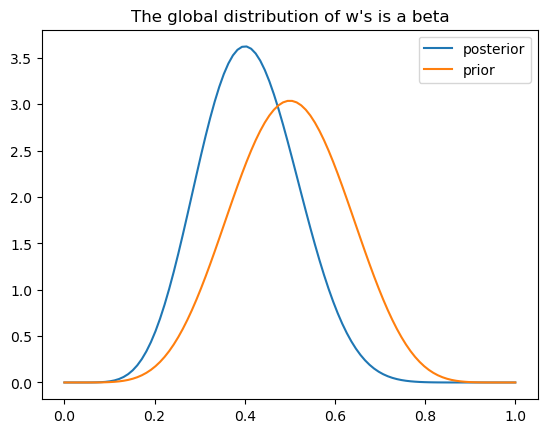

In [58]:
grid = np.linspace(0,1,100)
post = stats.beta(8.348,12.008).pdf(grid)
prior = stats.beta(7.5,7.5).pdf(grid)
plt.plot(grid,post,label="posterior")
plt.plot(grid,prior,label="prior")
plt.legend()
plt.title("The global distribution of w's is a beta")

# How to criticize a study for having a non-representative sample

We are finally ready to zoom out a return to our original question. When we read a study with a fairly selective sample, what should we make of it? One thing that makes a study not very useful is when you don't learn much from it. Bayesian inference has a natural way to describe what "not learning much" means. It means the distance between the prior and the posterior is very small. Studies conducted on only a selective sample provide very little information about the location of global hyperparameters. When we complain that "this study only looked at American university males" what we really mean is we learned almost nothing about some parameters of interest.

We can illustrate this visually. Consider what would happen if we tried to fit a multi-level model with only data from a single country. Using only a single country means there is almost no guidance at all for where to locate the hyperparameters.

In [61]:
with pm.Model() as model_multilevel_3:

    # global population priors

    mean = pm.Dirichlet('mean',[2,2])
    inverse_variance = pm.Exponential('inverse_variance',scale=15)
    hyper_parameter = mean * inverse_variance

    # cosmetic functions to make the model easier to summarize

    a = pm.Deterministic('a',hyper_parameter[0])
    b = pm.Deterministic('b',hyper_parameter[1])

    # mixture weights

    w0 = pm.Dirichlet('w0',hyper_parameter)

    # mixture components

    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y0 = pm.Mixture('error_0',w=w0,comp_dists=components,observed=us_mistakes_treatment)

    trace_us = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, inverse_variance, w0, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Notice that the `a,b` move but not very much.

In [62]:
az.summary(trace_us).loc[['a','b']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,10.230,9.460,0.059,28.483,0.172,0.124,2599.0,2268.0,1.0
b,7.356,6.564,0.026,19.538,0.123,0.089,2473.0,2157.0,1.0


Or, visually, this depicts the distance between the prior and the posterior and illustrates how little we've learned.

Text(0.5, 1.0, "The global distribution of w's is a beta")

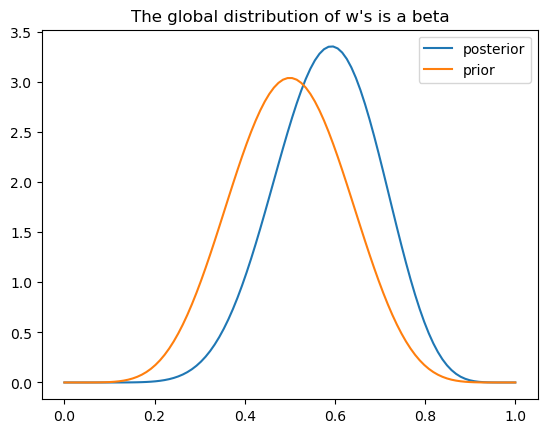

In [66]:
grid = np.linspace(0,1,100)
post = stats.beta(10.230,7.356).pdf(grid)
prior = stats.beta(7.5,7.5).pdf(grid)
plt.plot(grid,post,label="posterior")
plt.plot(grid,prior,label="prior")
plt.legend()
plt.title("The global distribution of w's is a beta")

Statistical models routinely underrepresent our uncertainty. They treat things as knows that are not by simplifying complicated processes. In many cases that is okay. If we tried to represent all our uncertainties simulatenously, we'd have extremely messy, difficult to use, difficult to interpret model. But when it comes to criticizing studies, we can build out missing assumptions and craft more careful representations of the world. In this case, we've added a multi-level structure to the Asch study in order to illustrate what we learn about the global distribution of conformity. Not so much. It's not groundbreaking. But it does allow us to think precisely about the problem space.

Consider, for example, if we have different priors describing the global distribution that were more uncertain. The original priors we built had no idea where to put the `w` parameters. In this case, we actually could learn more just by looking at a single case in America. Bayes exhibits an intuitive feature - the less information you have, the more impactful a single bit of learning is. The more information you have, the less important each additional bit of information is.

In [64]:
with pm.Model() as model_multilevel_4:

    mean = pm.Dirichlet('mean',[1,1])
    inverse_variance = pm.Exponential('inverse_variance',scale=2)
    hyper_parameter = mean * inverse_variance

    # cosmetic functions to make the model easier to summarize

    a = pm.Deterministic('a',hyper_parameter[0])
    b = pm.Deterministic('b',hyper_parameter[1])

    # mixture weights

    w0 = pm.Dirichlet('w0',hyper_parameter)

    # mixture components

    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y0 = pm.Mixture('error_0',w=w0,comp_dists=components,observed=us_mistakes_treatment)

    trace_us_bad_priors = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, inverse_variance, w0, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


Text(0.5, 1.0, "The global distribution of w's is a beta")

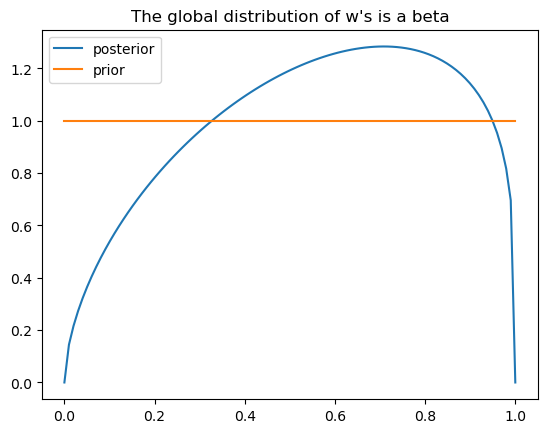

In [65]:
a_post = az.summary(trace_us_bad_priors).loc['a']['mean']
b_post = az.summary(trace_us_bad_priors).loc['b']['mean']

grid = np.linspace(0,1,100)
post = stats.beta(a_post,b_post).pdf(grid)
prior = stats.beta(1,1).pdf(grid)
plt.plot(grid,post,label="posterior")
plt.plot(grid,prior,label="prior")
plt.legend()
plt.title("The global distribution of w's is a beta")